# 23 years of hourly eletric energy demand (Brazil) time-series analysis
<img src = "https://storage.googleapis.com/kaggle-datasets-images/2828182/4877762/fd618f8f621417ba170ae03dc9372698/dataset-cover.jpg?t=2023-01-20-16-33-28">

- Kaggle dataset: https://www.kaggle.com/datasets/arusouza/23-years-of-hourly-eletric-energy-demand-brazil?select=energy_demand_hourly_brazil.csv

# Importing Packages

In [4]:
# Data Modeling
import pandas as pd
import numpy as np
from datetime import datetime

# Data preprocessing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose

# Models
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Validation
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

# Other Packages
import os

# Setting parameters
os.chdir(r'G:\Meu Drive\Estudo\Machine Learning\Specialized Models - Time Series and Survival Analysis')
sns.set_palette("dark")
sns.set_style("whitegrid")
RANDOM_SEED = np.random.seed(78)

# Data Modeling

## Importing data

In [5]:
df = pd.read_csv('energy_demand_hourly_brazil.csv')
df.head()

,index,hourly_demand
0,2000-01-01 00:00:00,34673.9
1,2000-01-01 01:00:00,33503.0
2,2000-01-01 02:00:00,32287.6
3,2000-01-01 03:00:00,31059.4
4,2000-01-01 04:00:00,30272.7


## Initial Exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201318 entries, 0 to 201317
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          201318 non-null  object 
 1   hourly_demand  201318 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.1+ MB


In [7]:
df.describe()

,hourly_demand
count,201318.000000
mean,54391.824054
std,12211.551397
min,0.000000
25%,45169.570000
50%,53929.597000
75%,63809.801228
max,90120.004000


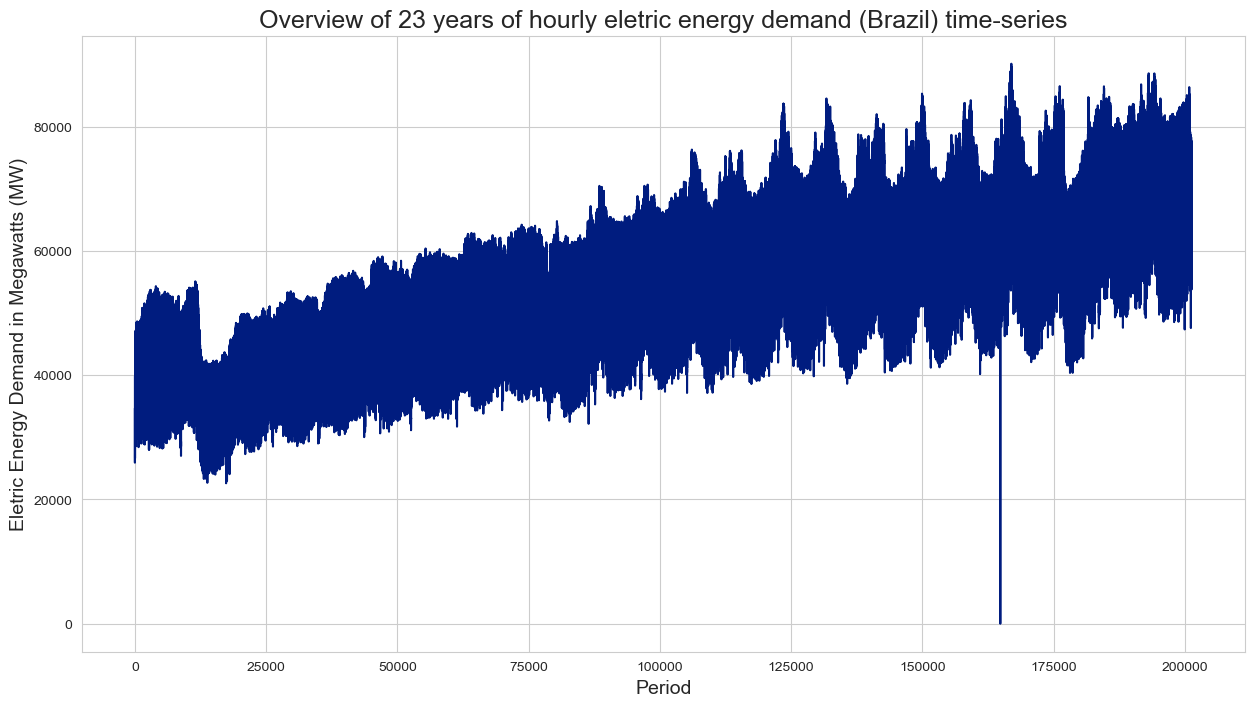

In [8]:
# Overview of the time series
plt.figure(figsize = (15, 8))
df['hourly_demand'].plot()
plt.title('Overview of 23 years of hourly eletric energy demand (Brazil) time-series', fontsize = 18)
plt.xlabel('Period', fontsize = 14)
plt.ylabel('Eletric Energy Demand in Megawatts (MW)', fontsize = 14)
plt.show()

## Setting the date as the index and creating columns for group by

In [9]:
# Parsing the dates column
df['index'] = df['index'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

# Seting index
df.set_index('index', inplace = True)

## Discarting some data
- I'll consider only complete months, so all the data of january 2023 (just one value) will be removed
- Data older than 2003 will be removed to eliminate non-standard behavior

In [10]:
selection = (df.index > '2003') & (df.index < '2023')
df = df[selection]

## Fixing the "0" outlier

In [11]:
# Locating the number
df[df['hourly_demand'] == 0]

,hourly_demand
index,
2018-11-04,0.0


In [12]:
# Changing the value to the mean of the day
df.loc[df['hourly_demand'] == 0, 'hourly_demand'] = df['hourly_demand'].loc['2018-11-04'].mean()

## Changing the granularity of the data

In [13]:
df_month = df.resample("M").sum()
df_month.head()

,hourly_demand
index,
2003-01-31,3.083039e+07
2003-02-28,2.923847e+07
2003-03-31,3.126018e+07
2003-04-30,3.009761e+07
2003-05-31,3.029473e+07


In [14]:
df_day = df.resample("D").sum()
df_day.head()

,hourly_demand
index,
2003-01-01,756874.59
2003-01-02,958083.52
2003-01-03,987460.71
2003-01-04,929165.94
2003-01-05,858729.45


# EDA

## Times series overview
__Observations:__
- We can clearly see that the series has a trend and some seasonality

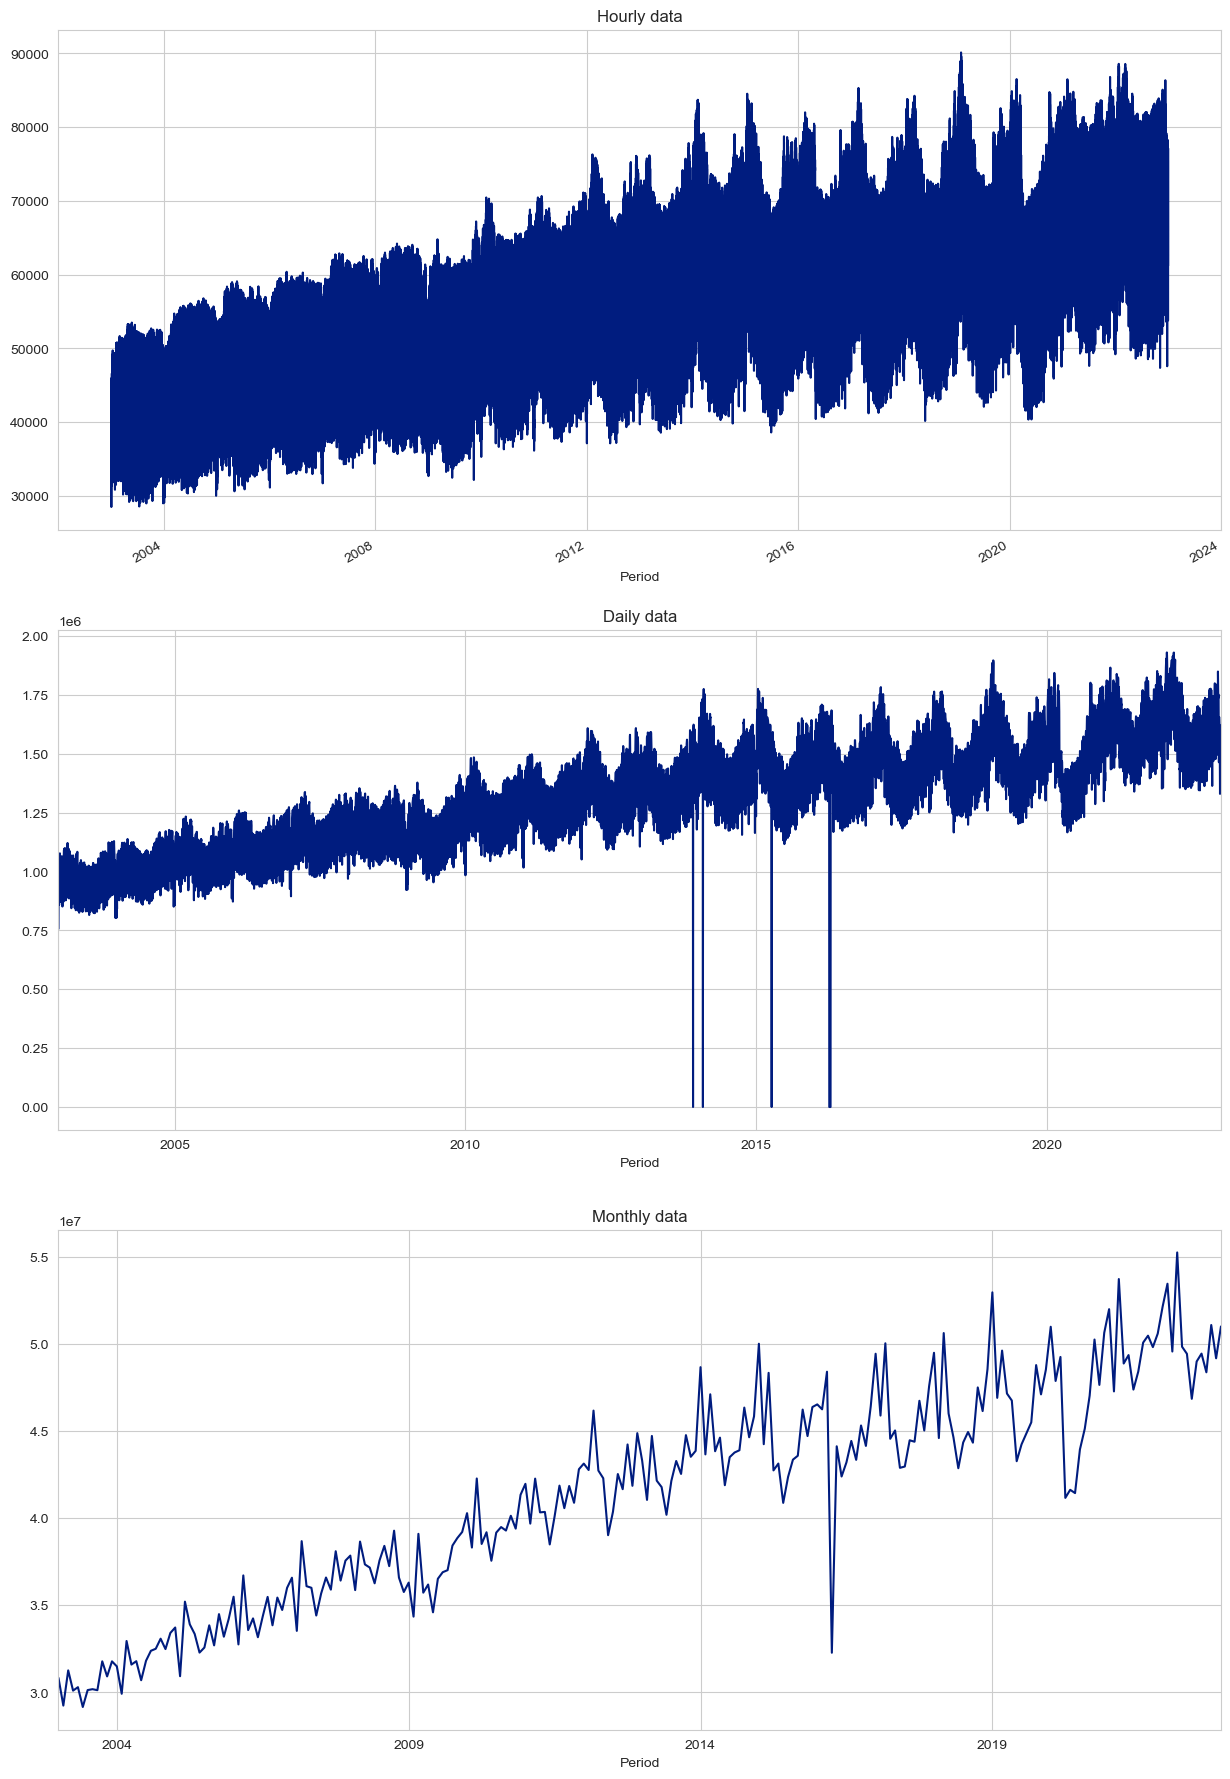

In [15]:
# Creating axes
fig, axes = plt.subplots(3, 1, sharex=False, sharey=False)
fig.set_figheight(25)
fig.set_figwidth(15)

# Plotting the hourly data
df['hourly_demand'].plot(ax = axes[0])
axes[0].set_title(f"Hourly data")
axes[0].set_xlabel("Period")

# Plotting the daily data
df_day['hourly_demand'].plot(ax = axes[1])
axes[1].set_title(f"Daily data")
axes[1].set_xlabel("Period")

# Plotting the monthly data
df_month['hourly_demand'].plot(ax = axes[2])
axes[2].set_title(f"Monthly data")
axes[2].set_xlabel("Period")

plt.show()

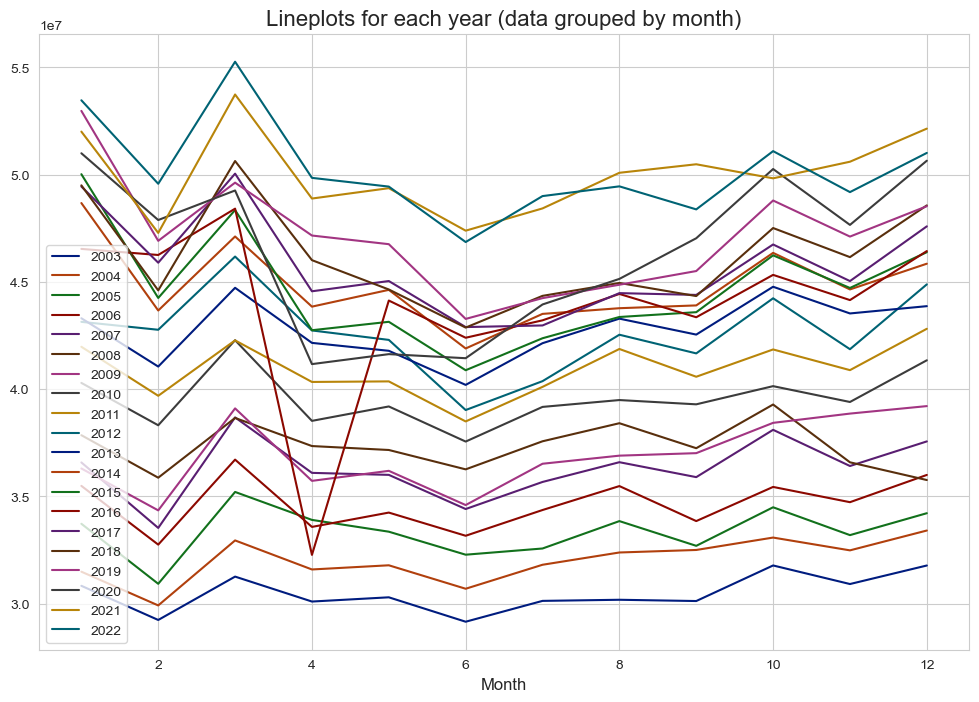

In [16]:
# Year comparison
plt.figure(figsize = (12, 8))
for year in range(2003, 2023):
    plt.plot(
        range(1, 13),
        df_month.loc[str(year)]['hourly_demand'],
        label = year
    )
plt.title('Lineplots for each year (data grouped by month)', fontsize = 16)
plt.xlabel('Month', fontsize = 12)
plt.legend()
plt.show()

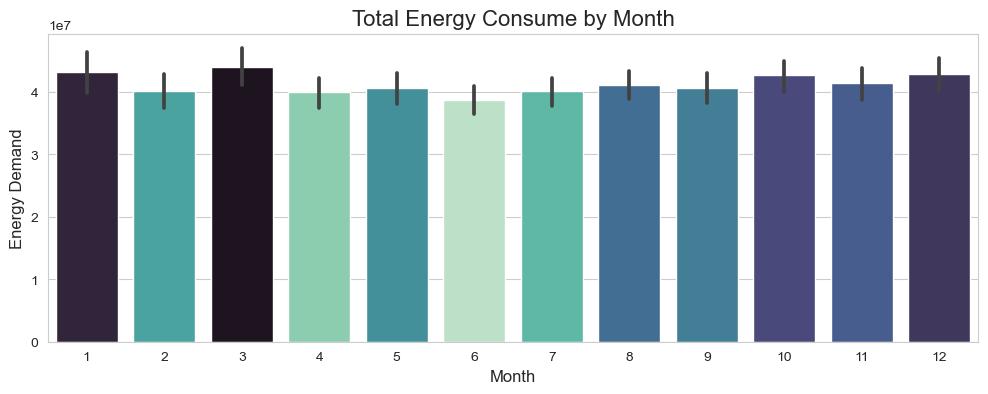

In [90]:
# Function to create a dynamic palette
def colors_from_values(values: pd.Series, palette_name:str, ascending=True):
    '''Returns a seaborn palette reordered by value
    Parameters:
    values: pd.Series
    palette_name:str, Seaborn valid palette name
    ascending: bool, optional color sort order
    '''
    # convert to indices
    values = values.sort_values(ascending=ascending).reset_index()
    indices = values.sort_values(by=values.columns[0]).index
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

# Creating the palette
month_series = df_month.groupby(df_month.index.month).agg({'hourly_demand' : 'sum'})['hourly_demand']

month_palette = colors_from_values(month_series, 'mako', False)


# Month comparison
plt.figure(figsize=(12, 4))
sns.barplot(
    y='hourly_demand',
    x=df_month.index.month,
    data=df_month,
    palette = month_palette
)

plt.title('Total Energy Consume by Month', fontsize=16)
plt.ylabel('Energy Demand', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.show()

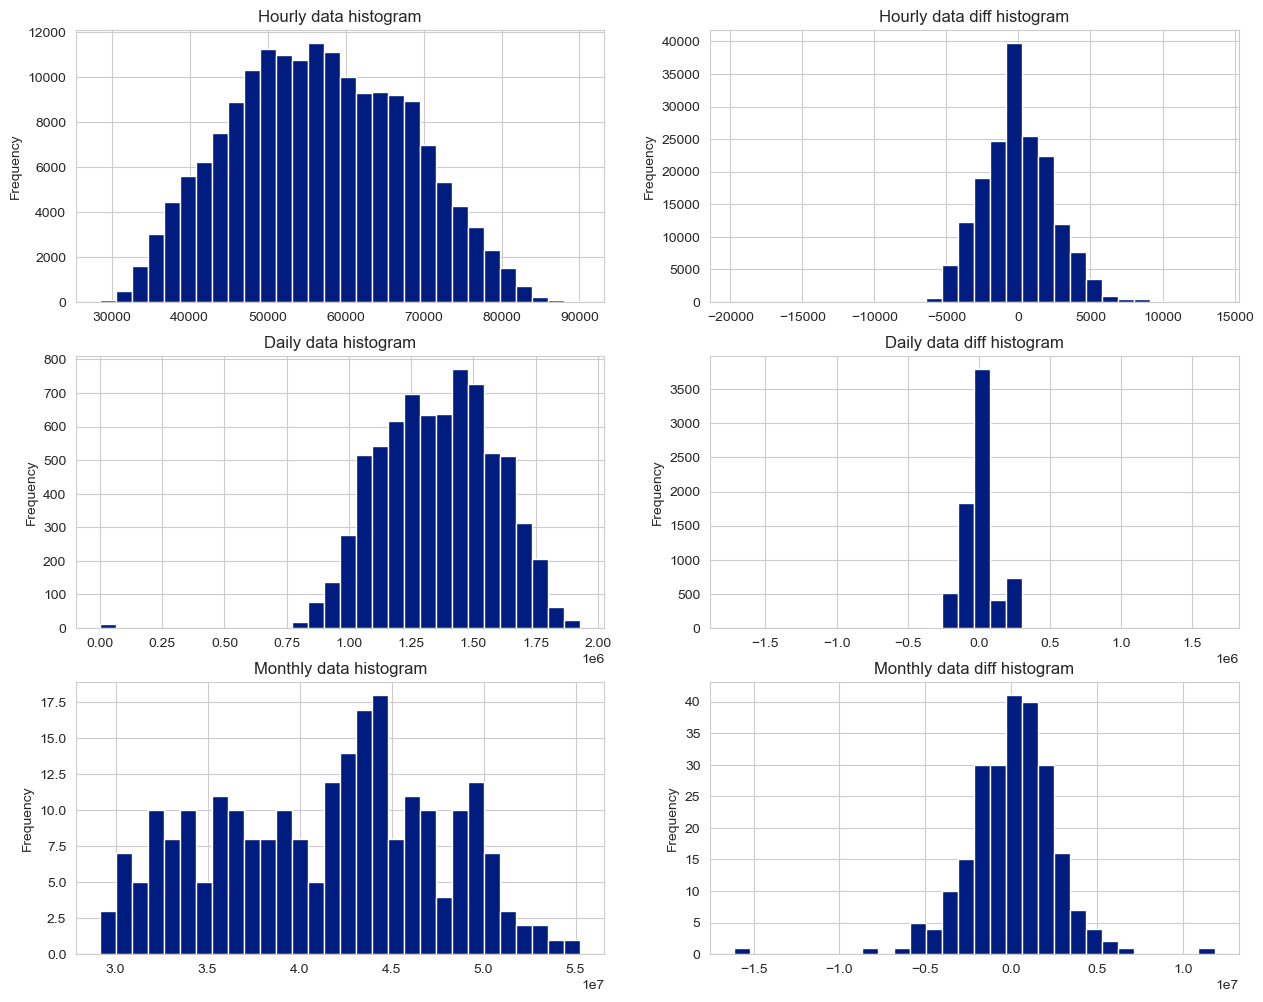

In [17]:
# Creating axes
fig, axes = plt.subplots(3, 2, sharex=False, sharey=False)
fig.set_figheight(12)
fig.set_figwidth(15)

# Plotting the histograms of the hourly data
df['hourly_demand'].plot(kind = 'hist', bins = 30, ax = axes[0, 0])
axes[0, 0].set_title(f"Hourly data histogram")

df['hourly_demand'].diff().plot(kind = 'hist', bins = 30, ax = axes[0, 1])
axes[0, 1].set_title(f"Hourly data diff histogram")

# Plotting the histograms of the daily data
df_day['hourly_demand'].plot(kind = 'hist', bins = 30,  ax = axes[1, 0])
axes[1, 0].set_title(f"Daily data histogram")

df_day['hourly_demand'].diff().plot(kind = 'hist', bins = 30,  ax = axes[1, 1])
axes[1, 1].set_title(f"Daily data diff histogram")

# Plotting the histograms of the monthly data
df_month['hourly_demand'].plot(kind = 'hist', bins = 30,  ax = axes[2, 0])
axes[2, 0].set_title(f"Monthly data histogram")

df_month['hourly_demand'].diff().plot(kind = 'hist', bins = 30,  ax = axes[2, 1])
axes[2, 1].set_title(f"Monthly data diff histogram")

plt.show()

## Stationarity
__Observations:__
- As we can see, the series is __NOT stationary__, just looking we can assert this by intuition, and the ADF test confirms it

In [18]:
# Augmented Dickey-Fuller (ADF)
adf_results = adfuller(df_month['hourly_demand'], regression = "ct")
print(f'ADF score: {adf_results[0] :.2f} | Pvalue: {adf_results[1] :.2f}')

ADF score: -2.82 | Pvalue: 0.19


## Self-correlantion
__Observations:__
- The ACF plots again confirms that our series is not stationary yet, as we can see high seft-correlation across the entire series, this could be cause by our high trend
- The PACF plots for hourly and daily data, have multiple critical values for high lags, which could indicate a seasonal cycle. On the other hand the monthly data has critical values at lags 1 and 2

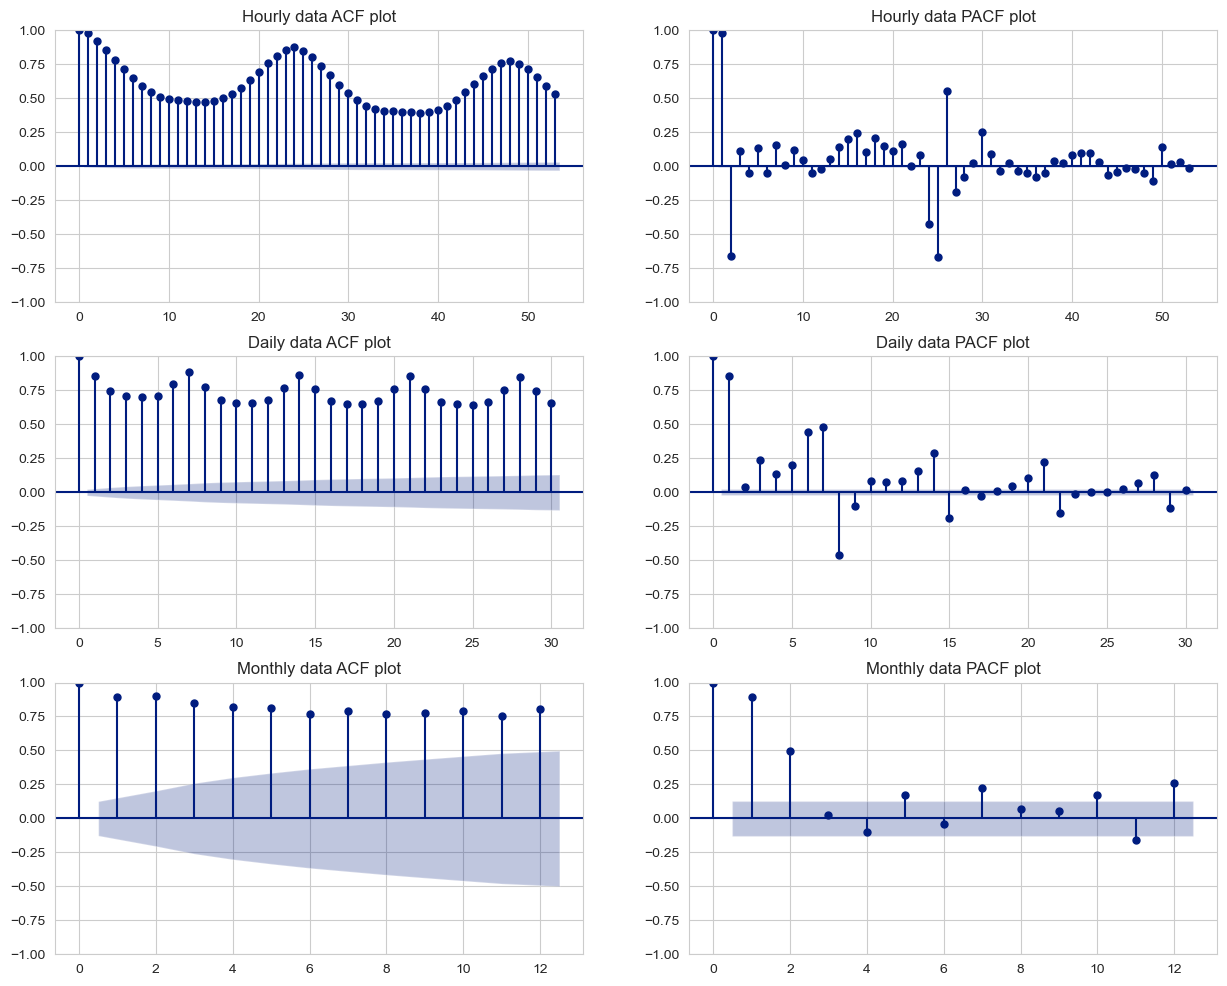

In [19]:
# Creating axes
fig, axes = plt.subplots(3, 2, sharex=False, sharey=False)
fig.set_figheight(12)
fig.set_figwidth(15)

# Plotting ACF and PACF for hourly data
plot_acf(df['hourly_demand'], ax = axes[0,0])
axes[0,0].set_title('Hourly data ACF plot')

plot_pacf(df['hourly_demand'], method='ywm', ax = axes[0, 1])
axes[0,1].set_title('Hourly data PACF plot')

# Plotting ACF and PACF for daily data
plot_acf(df_day['hourly_demand'], lags = 30, ax = axes[1,0])
axes[1,0].set_title('Daily data ACF plot')

plot_pacf(df_day['hourly_demand'], lags = 30, method='ywm', ax = axes[1, 1])
axes[1,1].set_title('Daily data PACF plot')

# Plotting ACF and PACF for monthly data
plot_acf(df_month['hourly_demand'], lags = 12, ax = axes[2,0])
axes[2,0].set_title('Monthly data ACF plot')

plot_pacf(df_month['hourly_demand'], lags = 12, method='ywm', ax = axes[2, 1])
axes[2,1].set_title('Monthly data PACF plot')

plt.show()

# Smoothing 
- The series clearly has trend and seasonality, so i'll use __triple exponencial smoothing__
- Just by intuition think that the series is multiplicative, but i'll run two smoothing process, one considering a additive series, and a second considering a multiplicative series

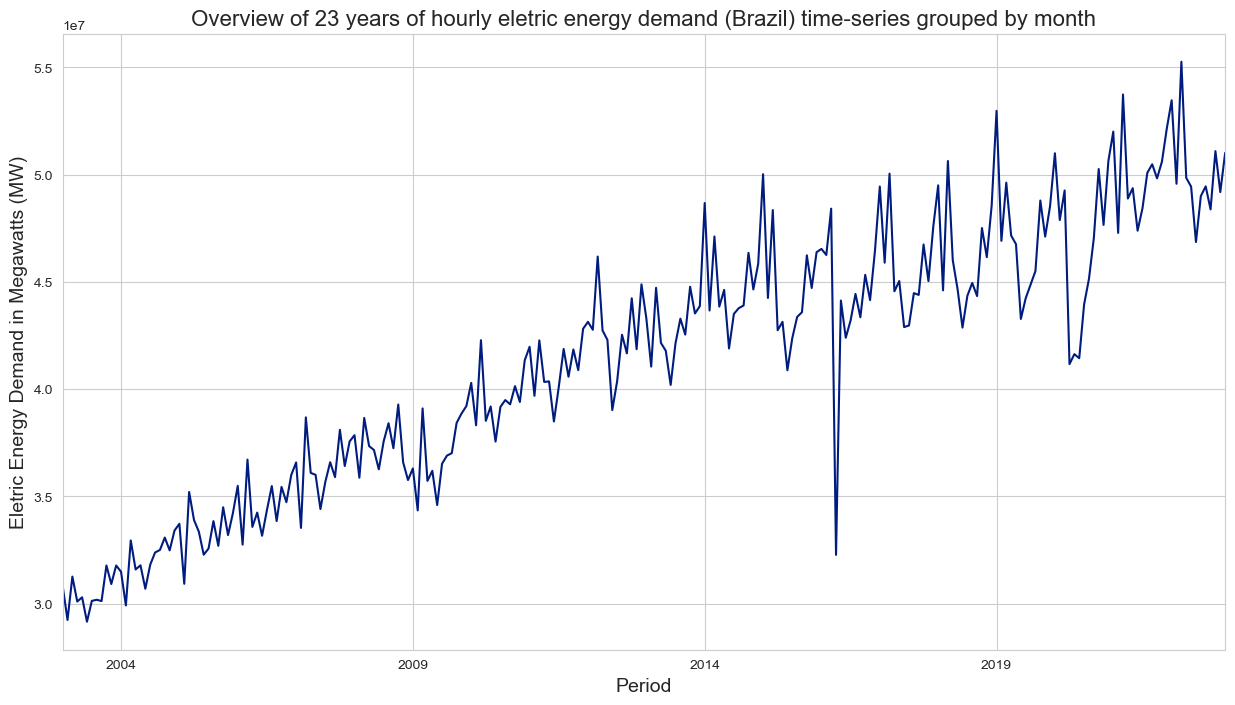

In [20]:
# Overview of the time series, just to refresh memory 
plt.figure(figsize = (15, 8))
df_month['hourly_demand'].plot()
plt.title('Overview of 23 years of hourly eletric energy demand (Brazil) time-series grouped by month', fontsize = 16)
plt.xlabel('Period', fontsize = 14)
plt.ylabel('Eletric Energy Demand in Megawatts (MW)', fontsize = 14)
plt.show()

In [21]:
# Smoothing additive model training
additive_model = ETSModel(
    df_month['hourly_demand'],
    error = 'add',
    trend = 'add',
    seasonal = 'add',
    seasonal_periods = 12
).fit()

# Smoothing amultiplicative model training
multiplicative_model = ETSModel(
    df_month['hourly_demand'],
    error = 'mul',
    trend = 'mul',
    seasonal = 'mul',
    seasonal_periods = 12
).fit()

In [22]:
# Creating series of smoothed values
smoothed_add_series = additive_model.predict()
smoothed_mult_series = multiplicative_model.predict()

## Results

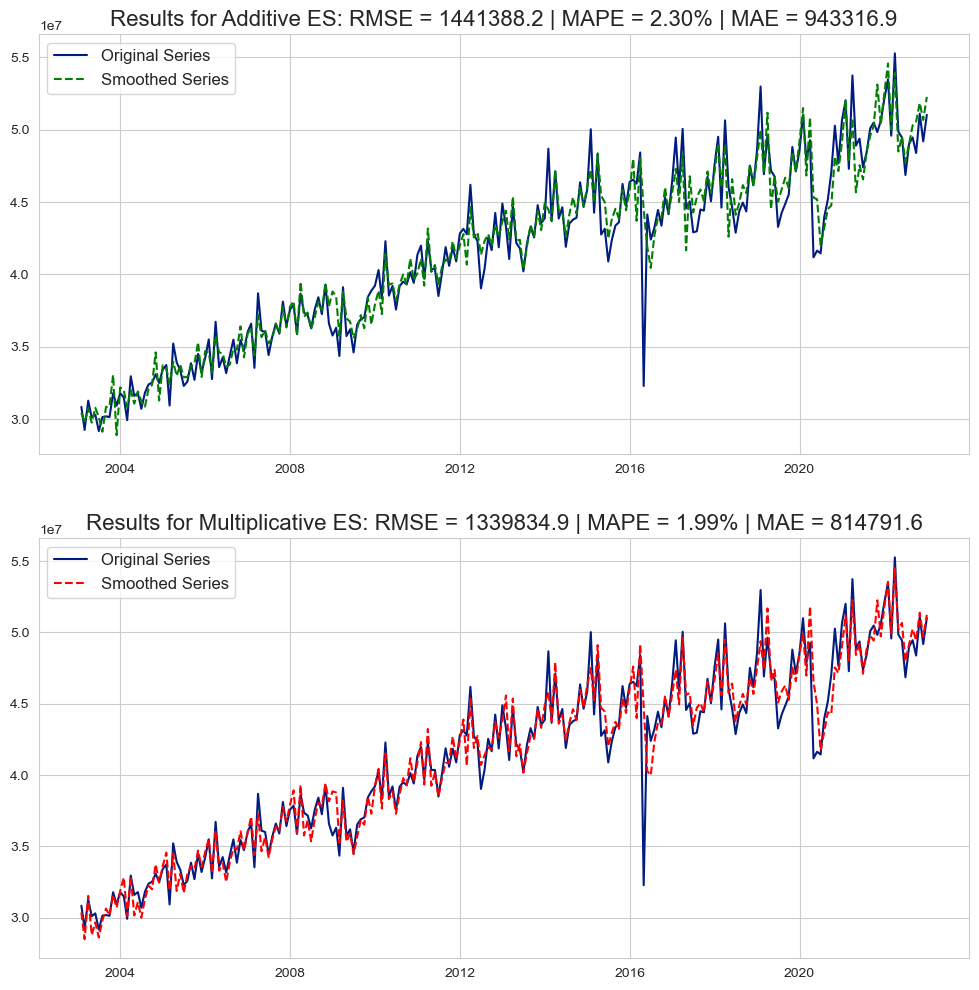

In [23]:
fig, axes = plt.subplots(2, 1)
fig.set_figheight(12)
fig.set_figwidth(12)

# Results for additive smoothing model
rmse = mean_squared_error(df_month['hourly_demand'], smoothed_add_series) ** 0.5
mape = mean_absolute_percentage_error(df_month['hourly_demand'], smoothed_add_series) * 100
mae = mean_absolute_error(df_month['hourly_demand'], smoothed_add_series)

axes[0].plot(df_month['hourly_demand'], label = 'Original Series')
axes[0].plot(smoothed_add_series, color = 'green', linestyle = 'dashed', label = 'Smoothed Series')
axes[0].set_title(f'Results for Additive ES: RMSE = {rmse:.1f} | MAPE = {mape:.2f}% | MAE = {mae:.1f}', fontsize = 16)
axes[0].legend(fontsize = 12)

# Results for multiplicative smoothing model
rmse = mean_squared_error(df_month['hourly_demand'], smoothed_mult_series) ** 0.5
mape = mean_absolute_percentage_error(df_month['hourly_demand'], smoothed_mult_series) * 100
mae = mean_absolute_error(df_month['hourly_demand'], smoothed_mult_series)

axes[1].plot(df_month['hourly_demand'], label = 'Original Series')
axes[1].plot(smoothed_mult_series, color = 'red', linestyle = 'dashed', label = 'Smoothed Series')
axes[1].set_title(f'Results for Multiplicative ES: RMSE = {rmse:.1f} | MAPE = {mape:.2f}% | MAE = {mae:.1f}', fontsize = 16)
axes[1].legend(fontsize = 12)

plt.show()

__Conclusions:__
- Choosing the parameters to be multiplicative gave us better results, so i'll use the multiplicative model
- I'll add the smoothed values to the df_month and will use them from now

In [24]:
# Adding the new column
df_month['smoothed_demand'] = smoothed_mult_series

# Visualizing the dataframe
df_month.head()

,hourly_demand,smoothed_demand
index,,
2003-01-31,3.083039e+07,3.035965e+07
2003-02-28,2.923847e+07,2.848530e+07
2003-03-31,3.126018e+07,3.152234e+07
2003-04-30,3.009761e+07,2.877837e+07
2003-05-31,3.029473e+07,2.965754e+07


# Model Selection

## ARIMA - Manual Parameters

### Fiding the parameters (p, d, q)

#### Number of diferentiations (d)
- For the "d" parameter, i mean the number of differentiations that we'll do, i'll test from 1 to 3, plotting the new series and the result of ADF test

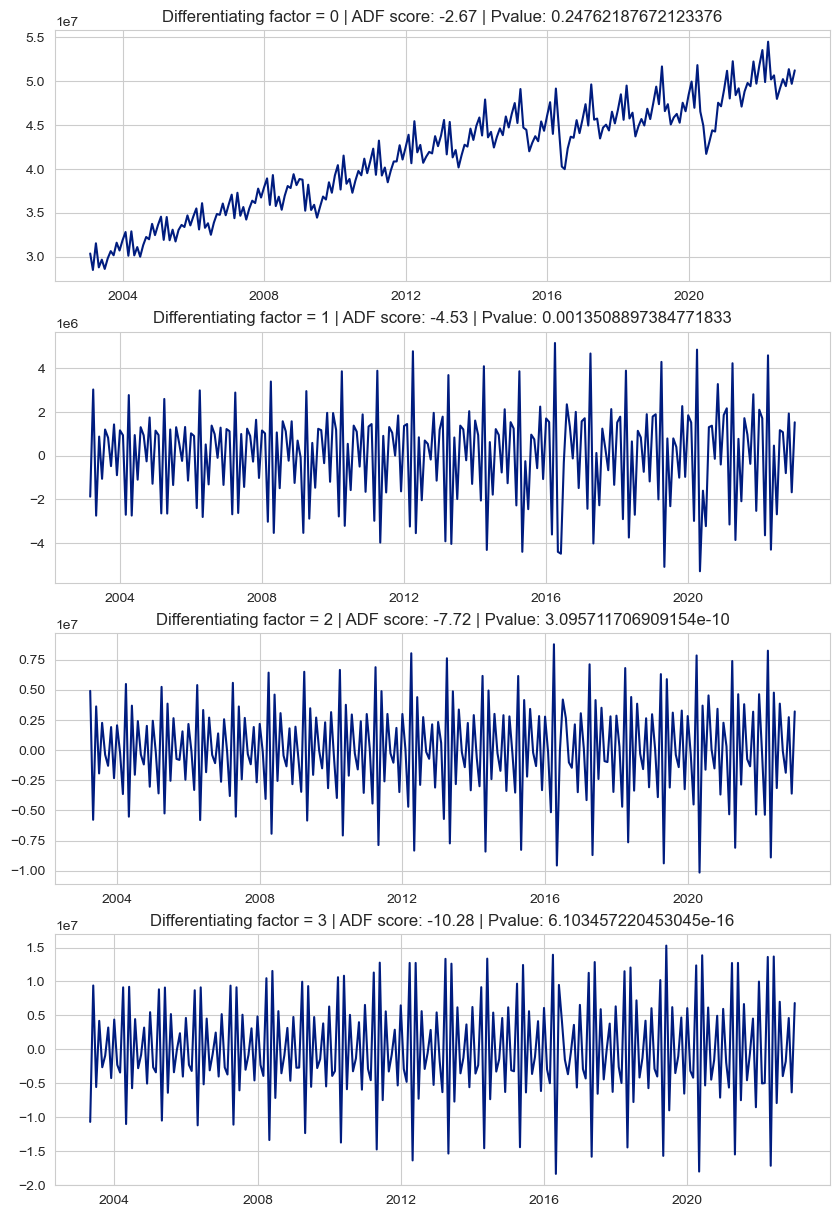

In [25]:
fig, axes = plt.subplots(4, 1)
fig.set_figheight(15)
fig.set_figwidth(10)

# Testing the number of diferentiations
for d in range(4):
    
    series = df_month['smoothed_demand']
    
    # Differencing the series
    for i in range(d):
        series = series.diff().dropna()
        
    # Adf test
    results = adfuller(series, regression = "ct")
    
    # Plotting
    axes[d].plot(series)
    axes[d].set_title(f'Differentiating factor = {d} | ADF score: {results[0] :.2f} | Pvalue: {results[1]}')

__Conclusion__
- So, for the parameter "d", i'll choose d = 1, cause it gave us a already good result

In [26]:
series = df_month['smoothed_demand'].diff().dropna()

#### MA parameter (q)
- For this parameter, i'll analyse a ACF plot of the smoothed/differentiated data

[]

<Figure size 1500x1200 with 0 Axes>

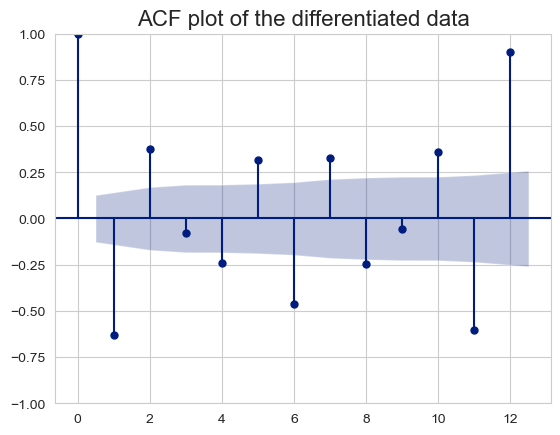

In [27]:
plt.figure(figsize = (15, 12))
plot_acf(series, lags = 12)
plt.title('ACF plot of the differentiated data', fontsize = 16)
plt.plot()

__Conclusion__
- Looks like 2 is the best choice for "q"

#### AR parameter (p)
- For this parameter, i'll analyse a PACF plot of the smoothed/differentiated data

[]

<Figure size 1500x1200 with 0 Axes>

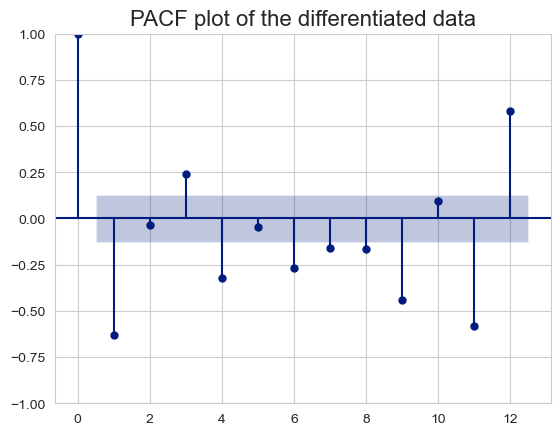

In [28]:
plt.figure(figsize = (15, 12))
plot_pacf(series, lags = 12, method='ywm')
plt.title('PACF plot of the differentiated data', fontsize = 16)
plt.plot()

__Conclusion__
- Looks like 1 is the best choice for "p"

### Testing the parameters

#### Splitting the dataset
- to train the model i'll be using the data until 2021, and the 2022 data will be used for validation

In [29]:
train = df_month['smoothed_demand'][:-12]
test = df_month['smoothed_demand'][-12:]

In [30]:
# Last 5 values of train dataset
train.tail()

index
2021-08-31    4.979910e+07
2021-09-30    4.942889e+07
2021-10-31    5.224591e+07
2021-11-30    4.972035e+07
2021-12-31    5.182985e+07
Freq: M, Name: smoothed_demand, dtype: float64

In [31]:
# All values of test dataset
test.head(12)

index
2022-01-31    5.354827e+07
2022-02-28    4.990339e+07
2022-03-31    5.450504e+07
2022-04-30    5.020149e+07
2022-05-31    5.066650e+07
2022-06-30    4.798275e+07
2022-07-31    4.915470e+07
2022-08-31    5.023570e+07
2022-09-30    4.943984e+07
2022-10-31    5.137529e+07
2022-11-30    4.970126e+07
2022-12-31    5.123418e+07
Freq: M, Name: smoothed_demand, dtype: float64

#### Training the model

In [32]:
arima_model = ARIMA(
    train,
    order = (1, 1, 2),
    seasonal_order = (1, 1, 2, 12), # Using (P, D, Q, s) as (p, d, q, 12)
    dates = df_month.index,
    freq = 'M'
).fit()

#### Results

In [33]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                  smoothed_demand   No. Observations:                  228
Model:             ARIMA(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -3199.112
Date:                          Mon, 06 Mar 2023   AIC                           6412.223
Time:                                  10:42:15   BIC                           6435.818
Sample:                              01-31-2003   HQIC                          6421.757
                                   - 12-31-2021                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6061      1.473     -0.411      0.681      -3.493       2.281
ma.L1          0.6420      1.486      0.432      0.666      -2.270       3.554
ma.L2       1.956e-05      0.086      0.000      1.000      -0.168       0.168
ar.S.L12       0.5303      0.115      4.596      0.000       0.304       0.756
ma.S.L12      -0.7125      0.122     -5.828      0.000      -0.952      -0.473
ma.S.L24      -0.0269      0.026     -1.039      0.299      -0.078       0.024
sigma2       5.43e+11   2.31e-11   2.35e+22      0.000    5.43e+11    5.43e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               962.64
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               4.84   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.34e+37. Standard errors may be unstable.
"""

[]

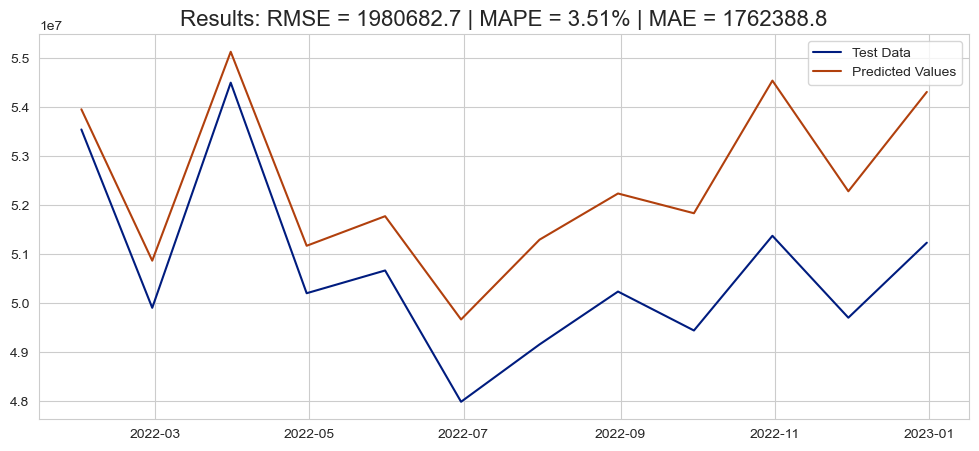

In [34]:
# Predicting the year of 2022
arima_forecast = arima_model.get_forecast(12)
predicted_values = arima_forecast.predicted_mean

# Results of the predictions
rmse = mean_squared_error(test, predicted_values) ** 0.5
mape = mean_absolute_percentage_error(test, predicted_values) * 100
mae = mean_absolute_error(test, predicted_values)

# Plotting
plt.figure(figsize = (12, 5))
plt.plot(test, label = 'Test Data')
plt.plot(predicted_values, label = 'Predicted Values')
plt.legend()
plt.title(f'Results: RMSE = {rmse:.1f} | MAPE = {mape:.2f}% | MAE = {mae:.1f}', fontsize = 16)
plt.plot()

## Auto ARIMA

#### Training the model

In [35]:
# Setting the model parameters
auto_arima_model = pm.auto_arima(
    train,                            # Train data
    start_p = 0, d = 1 , start_q = 0, # Start order params
    max_p = 2, max_d = 2, max_q = 2,  # Max order params
    start_P = 0, D = 1, start_Q = 0,  # Start seasonal order params
    max_P = 2, max_D = 2, max_Q = 2,  # Max seasonal order params
    m = 12,                           # Period of the data
    seasonal = True,
    trace = True,                     # Print the fit status
    random_state = 78,                # Ensures replicable results
    error_action='ignore',  
    suppress_warnings=True,
    stepwise = False,
    n_jobs = -1                       # Setting the number of interations to me as many as possible
)

# Using AIC to choose the best parameters
print(auto_arima_model.aic())


Best model:  ARIMA(1,1,0)(1,1,1)[12]          
Total fit time: 52.389 seconds
6407.9066922936345


In [36]:
# Using the parameters to fit the model
auto_arima_model = ARIMA(
    train,
    order = (1, 1, 0),
    seasonal_order = (1, 1, 1, 12),
    dates = df_month.index,
    freq = 'M'
).fit()

#### Results

In [37]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    smoothed_demand   No. Observations:                  228
Model:             ARIMA(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -3199.953
Date:                            Mon, 06 Mar 2023   AIC                           6407.907
Time:                                    10:43:09   BIC                           6421.389
Sample:                                01-31-2003   HQIC                          6413.354
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0355      0.038      0.945      0.345      -0.038       0.109
ar.S.L12       0.6254      0.075      8.363      0.000       0.479       0.772
ma.S.L12      -0.8012      0.080    -10.045      0.000      -0.958      -0.645
sigma2      5.383e+11   8.13e-14   6.62e+24      0.000    5.38e+11    5.38e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1025.86
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               5.26   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.17e+40. Standard errors may be unstable.
"""

[]

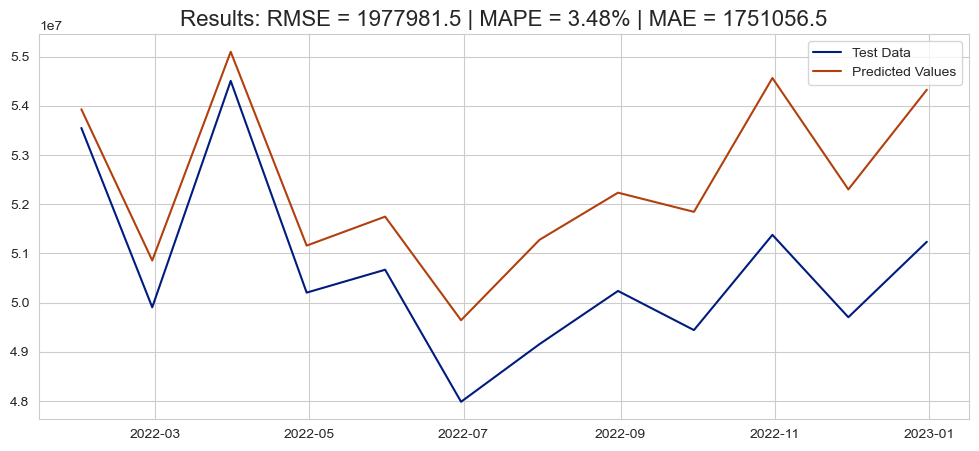

In [38]:
# Predicting the year of 2022
auto_arima_forecast = auto_arima_model.get_forecast(12)
predicted_values = auto_arima_forecast.predicted_mean

# Results of the predictions
rmse = mean_squared_error(test, predicted_values) ** 0.5
mape = mean_absolute_percentage_error(test, predicted_values) * 100
mae = mean_absolute_error(test, predicted_values)

# Plotting
plt.figure(figsize = (12, 5))
plt.plot(test, label = 'Test Data')
plt.plot(predicted_values, label = 'Predicted Values')
plt.legend()
plt.title(f'Results: RMSE = {rmse:.1f} | MAPE = {mape:.2f}% | MAE = {mae:.1f}', fontsize = 16)
plt.plot()

# Using the model

In [39]:
# Training the model using all the data
model = ARIMA(
    df_month['smoothed_demand'],
    order = (1, 1, 0),
    seasonal_order = (1, 1, 1, 12),
    dates = df_month.index,
    freq = 'M'
).fit()

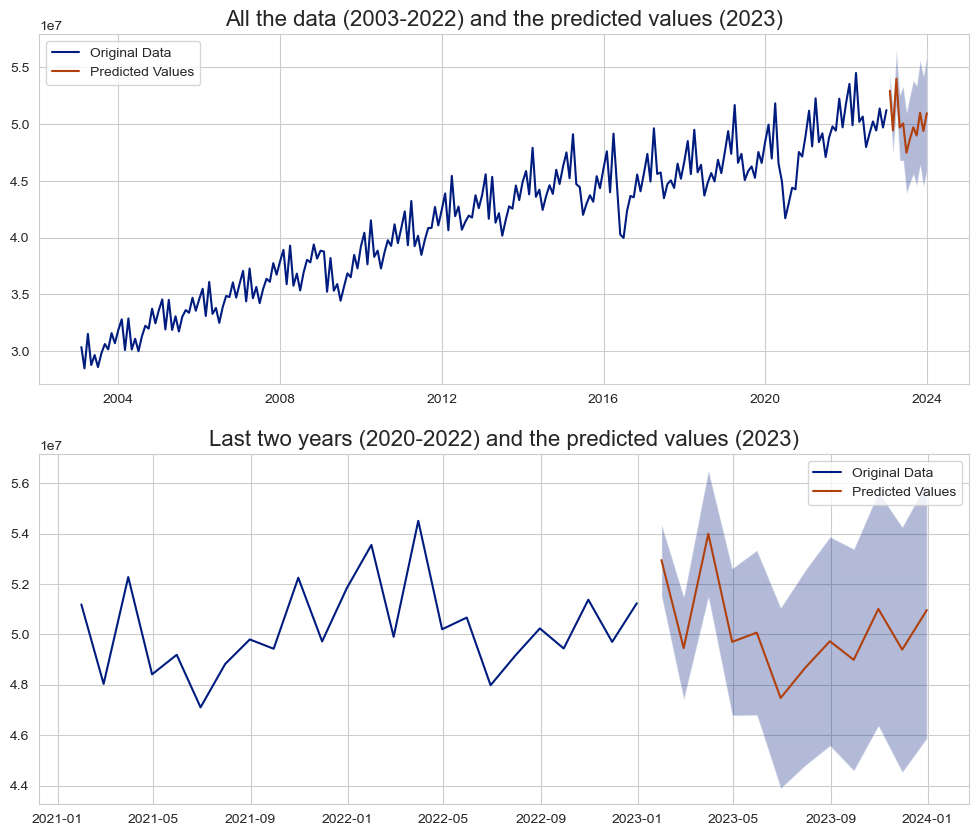

In [40]:
# Predicting 2023 energy demand
forecast_2023 = model.get_forecast(12)
mean_values = forecast_2023.predicted_mean
confidence_interval = forecast_2023.conf_int(alpha = 0.05)

# Plotting
fig, axes = plt.subplots(2, 1)
fig.set_figheight(10)
fig.set_figwidth(12)

# Complete data
axes[0].plot(df_month['smoothed_demand'], label = 'Original Data')
axes[0].plot(mean_values, label = 'Predicted Values')
axes[0].fill_between(
    confidence_interval.index, 
    confidence_interval['lower smoothed_demand'], 
    confidence_interval['upper smoothed_demand'],
    alpha = 0.3
)
axes[0].legend()
axes[0].set_title('All the data (2003-2022) and the predicted values (2023)', fontsize = 16)

# Only the last 2 years
axes[1].plot(df_month['smoothed_demand'][-24:], label = 'Original Data')
axes[1].plot(mean_values, label = 'Predicted Values')
axes[1].fill_between(
    confidence_interval.index, 
    confidence_interval['lower smoothed_demand'], 
    confidence_interval['upper smoothed_demand'],
    alpha = 0.3 # It isn't confidence interval, it's just opacity
)

axes[1].legend()
axes[1].set_title('Last two years (2020-2022) and the predicted values (2023)', fontsize = 16)

plt.show()

In [41]:
# DataFrame with the results
df_predictions = pd.DataFrame({
    'Prediction' : mean_values,
    'Max Value' : confidence_interval['upper smoothed_demand'],
    'Min Value' : confidence_interval['lower smoothed_demand']
})

df_predictions

,Prediction,Max Value,Min Value
2023-01-31,5.294591e+07,5.436695e+07,5.152488e+07
2023-02-28,4.945402e+07,5.149925e+07,4.740878e+07
2023-03-31,5.399317e+07,5.651345e+07,5.147289e+07
2023-04-30,4.970240e+07,5.262144e+07,4.678336e+07
2023-05-31,5.006903e+07,5.333856e+07,4.679951e+07
2023-06-30,4.747619e+07,5.106210e+07,4.389027e+07
2023-07-31,4.867648e+07,5.255305e+07,4.479991e+07
2023-08-31,4.972495e+07,5.387185e+07,4.557804e+07
2023-09-30,4.899007e+07,5.339073e+07,4.458941e+07
2023-10-31,5.100728e+07,5.564784e+07,4.636672e+07
